In [1]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.window import Window
import pyspark.sql.types as sparktypes

In [2]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '128G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", 0)
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/data3/epyc/projects3/ecbellm/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [3]:
spark_session

https://epyc.astro.washington.edu/jupyter/user/ecbellm/proxy/4060/jobs/

In [4]:
catalog.list_tables().keys()

dict_keys(['gaia_dr2_1am_dup', 'allwise_1am_dup', 'unwise_v1', 'cklein_flare', 'unwise_v2', 'catalina_variables_n', 'gaia', 'gaia_dr2_1am_dup_ssd', 'ps1', 'green19_stellar_params', 'rosat_2rxs', 'rosat_2rxs_z4am_b2am', 'ztf_dr3_2rxs_obj', 'wtf_ztf_dr3', 'ztf_wds_kjb_dr3', 'karenws_cut_wtf_fits_r_band', 'karenws_cut_wtf_fits', 'ztf_aug2020_2rxs_obj', 'skymapper_dr2', 'test_skymapper', 'skymapper_dr2_ver2', 'skymapper_dr2_ver3', 'ztf_rrlyr', 'gaia_source_edr3', 'gaia_edr3_distances', 'rrlyrae_sample_andy', 'stevengs_test_small_df', 'ztf5', 'feh_rrlyr_ab_020620', 'kepler_rrlyrae', 'ztf_kepler_rrlyrae', 'ps_uband', 'ps_uband_ver2', 'debug_match_a', 'debug_match_b', 'debug_match_c', 'ztf_rrlyr_grid_50', 'igaps_halpha_emitters', 'wtf_aug2020_asymmetric_2', 'wtf_aug2020_asymmetric_3', 'wtf_aug2020_dip_candidates', 'ztf_rr_lyrae_preprocessed_and_gridded_09_01_2021', 'ztf_rr_lyrae_phi_31_fits_09_01_2021', 'stevengs_test_sources', 'ddf_sources_bigger', 'ztf_dr7', 'jrad_zg98m', 'jrad_zgd98m', 'jr

Building the Detection Table
=======

In [5]:
base_path = "/epyc/data/ztf_matchfiles/scratch_dr14_bulk_ztf_parquet_for_axs"
ztf_detections = spark_session.read.parquet(base_path + "/[01]/*/ztf_*_data.parquet")

In [6]:
ztf_detections

DataFrame[objectid: bigint, ra: float, dec: float, mjd_g: array<double>, mag_g: array<float>, magerr_g: array<float>, clrcoeff_g: array<float>, catflags_g: array<smallint>, rcid_g: array<smallint>, fieldid_g: array<smallint>, mjd_r: array<double>, mag_r: array<float>, magerr_r: array<float>, clrcoeff_r: array<float>, catflags_r: array<smallint>, rcid_r: array<smallint>, fieldid_r: array<smallint>, mjd_i: array<double>, mag_i: array<float>, magerr_i: array<float>, clrcoeff_i: array<float>, catflags_i: array<smallint>, rcid_i: array<smallint>, fieldid_i: array<smallint>, __index_level_0__: bigint]

In [6]:
# checks quickly for broken files
ztf_detections.count()

4473700524

In [7]:
%%time

catalog.save_axs_table(ztf_detections, "ztf_dr14_detections", calculate_zone=True)

CPU times: user 1min 2s, sys: 43.1 s, total: 1min 45s
Wall time: 4d 15h 28min 48s


Match in sections
======

In [5]:
ps1 = catalog.load("ps1")

In [6]:
ztf_detections = catalog.load("ztf_dr14_detections")

In [7]:
ztf_detections.columns

['objectid',
 'ra',
 'dec',
 'mjd_g',
 'mag_g',
 'magerr_g',
 'clrcoeff_g',
 'catflags_g',
 'rcid_g',
 'fieldid_g',
 'mjd_r',
 'mag_r',
 'magerr_r',
 'clrcoeff_r',
 'catflags_r',
 'rcid_r',
 'fieldid_r',
 'mjd_i',
 'mag_i',
 'magerr_i',
 'clrcoeff_i',
 'catflags_i',
 'rcid_i',
 'fieldid_i',
 '__index_level_0__',
 'zone',
 'dup']

In [8]:
def crossmatch_in_zone_band(detections_table, ps1, min_zone, max_zone, base_name):
    
    match_result = detections_table.where((detections_table['zone'] >= int(min_zone)) &
                                            (detections_table['zone'] < int(max_zone))).crossmatch(
        ps1.exclude_duplicates().select("ra", "dec", "zone", "dup", "objID",
                                        "gMeanPSFMag", "rMeanPSFMag", "iMeanPSFMag"), return_min=False)

    w = Window.partitionBy(sparkfunc.col("zone"), sparkfunc.col("objectid"),
                           sparkfunc.col("objID")).orderBy(sparkfunc.col("axsdist"))
    best_matches = match_result.withColumn("axsrownum",
                                         sparkfunc.row_number().over(w)).where(
                                         sparkfunc.col("axsrownum") == 1).drop("axsrownum")

    best_matches.createOrReplaceTempView("ztf_best_matches")

    q = spark_session.sql("SELECT objid as ps1_objid, avg(ra) as ra, avg(dec) as dec, zone, "
                          "first(gMeanPSFMag) as ps1_gMeanPSFMag, "
                          "first(rMeanPSFMag) as ps1_rMeanPSFMag, "
                          "first(iMeanPSFMag) as ps1_iMeanPSFMag, "
                          "collect_list(ra) as ra_detections, "
                          "collect_list(dec) as dec_detections, "                      
                          "flatten(collect_list(mjd_g)) as mjd_g, "
                          "flatten(collect_list(mag_g)) as mag_g, "
                          "flatten(collect_list(magerr_g)) as magerr_g, "
                          "flatten(collect_list(catflags_g)) as catflags_g, "
                          "flatten(collect_list(rcid_g)) as rcID_g, "
                          "flatten(collect_list(fieldid_g)) as fieldID_g, "
                          ""
                          "flatten(collect_list(mjd_r)) as mjd_r, "
                          "flatten(collect_list(mag_r)) as mag_r, "
                          "flatten(collect_list(magerr_r)) as magerr_r, "
                          "flatten(collect_list(catflags_r)) as catflags_r, "
                          "flatten(collect_list(rcid_r)) as rcID_r, "
                          "flatten(collect_list(fieldid_r)) as fieldID_r, "                  
                          ""
                          "flatten(collect_list(mjd_i)) as mjd_i, "
                          "flatten(collect_list(mag_i)) as mag_i, "
                          "flatten(collect_list(magerr_i)) as magerr_i, " 
                          "flatten(collect_list(catflags_i)) as catflags_i, "
                          "flatten(collect_list(rcid_i)) as rcID_i, "
                          "flatten(collect_list(fieldid_i)) as fieldID_i "
                          ""
                          "FROM ztf_best_matches "
                          "GROUP BY zone, objid")
    
    q.createOrReplaceTempView('q')
    # mean function from https://stackoverflow.com/questions/55502546/find-mean-of-pyspark-arraydouble
    q2 = spark_session.sql("""SELECT *, cardinality(mjd_g) AS nobs_g,
                        cardinality(mjd_r) AS nobs_r, cardinality(mjd_i) AS nobs_i,
                        aggregate(mag_g, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_g)) AS  mean_mag_g,
                        aggregate(mag_r, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_r)) AS  mean_mag_r,
                        aggregate(mag_i, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_i)) AS  mean_mag_i
                        FROM q""")

    q2.write.parquet("/epyc/projects3/ztf_axs_scratch/{:s}_zone{:05d}_{:05d}.parquet".format(base_name, min_zone, max_zone))


In [9]:
ztf_detections.select(sparkfunc.min(ztf_detections['zone']),
                                sparkfunc.max(ztf_detections['zone'])).collect()


[Row(min(zone)=3557, max(zone)=10752)]

In [10]:
zone_chunk_starts = np.arange(3500, 10901, 150)

In [11]:
zone_chunk_starts

array([ 3500,  3650,  3800,  3950,  4100,  4250,  4400,  4550,  4700,
        4850,  5000,  5150,  5300,  5450,  5600,  5750,  5900,  6050,
        6200,  6350,  6500,  6650,  6800,  6950,  7100,  7250,  7400,
        7550,  7700,  7850,  8000,  8150,  8300,  8450,  8600,  8750,
        8900,  9050,  9200,  9350,  9500,  9650,  9800,  9950, 10100,
       10250, 10400, 10550, 10700, 10850])

In [ ]:
%%time
for n, (min_zone, max_zone) in enumerate(zip(zone_chunk_starts[:-1], zone_chunk_starts[1:])):
    print(min_zone, max_zone)
    crossmatch_in_zone_band(ztf_detections, ps1, min_zone, max_zone, "ztf_dr14")

3500 3650
3650 3800


Combine strips
========

In [4]:
union_of_shards = spark_session.read.parquet("/epyc/projects3/ztf_axs_scratch/ztf_dr14*.parquet")

In [5]:
union_of_shards

DataFrame[ps1_objid: bigint, ra: double, dec: double, zone: bigint, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<double>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<double>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<double>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double]

In [ ]:
union_of_shards.head()

In [8]:
catalog.drop_table("ztf_dr14")

Table or view not found: ztf_dr14;


In [9]:
%%time
catalog.save_axs_table(union_of_shards.drop("zone"), "ztf_dr14", calculate_zone=True)

CPU times: user 14.4 s, sys: 9.55 s, total: 24 s
Wall time: 1d 1h 35min 17s


Validation
======

In [10]:
ztf_det = catalog.load("ztf_dr14_detections")

In [11]:
ztf_det.count()

0

In [12]:
ztf = catalog.load("ztf_dr14")

In [13]:
ztf.count()

1440550764

In [14]:
ztf.exclude_duplicates().count()

1234463018

In [15]:
ztf

AxsFrame[ps1_objid: bigint, ra: double, dec: double, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<double>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<double>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<double>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double, zone: bigint, dup: int]

In [22]:
# need to replace this with region to be faster
dflc = ztf.cone(284.6728604,22.6582771,2/3600).exclude_duplicates().select('*').toPandas()

In [23]:
dflc[['ps1_objid','ra','dec','nobs_g','nobs_r','nobs_i']]

,ps1_objid,ra,dec,nobs_g,nobs_r,nobs_i
0,135192846728780490,284.672963,22.658287,1,139,0


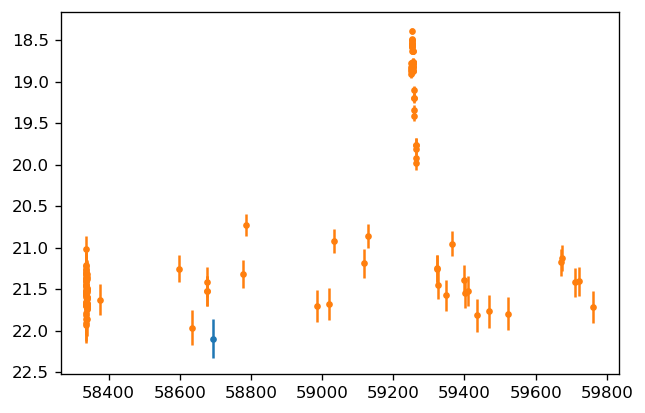

In [24]:
plt.figure()
lc = dflc.loc[0]

plt.errorbar(lc['mjd_g'],lc['mag_g'],lc['magerr_g'],fmt='.',ls='none')
plt.errorbar(lc['mjd_r'],lc['mag_r'],lc['magerr_r'],fmt='.',ls='none')
plt.gca().invert_yaxis()

In [17]:

def histogram2d(axsframe, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
    """
    Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
    x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
    If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
    through the data.
    The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
    `matplotlib.pcolormesh`.
    :param cond1: Column expression determining the data on x axis.
    :param cond2: Column expression determining the data on y axis.
    :param numbins1: Number of bins for x axis.
    :param numbins2: Number of bins for y axis.
    :param min1: Optional minimum value for x axis data.
    :param max1: Optional maximum value for x axis data.
    :param min2: Optional minimum value for y axis data.
    :param max2: Optional maximum value for y axis data.
    :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
    """
    colname1 = "axs_hist_col1"
    colname2 = "axs_hist_col2"
    res = axsframe._df.select(cond1.alias(colname1), cond2.alias(colname2))

    if min1 is None or max1 is None or min2 is None or max2 is None:
        mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                        F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
            collect()
        (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])

    range1 = float(max1 - min1)
    range2 = float(max2 - min2)
    step1 = range1 / numbins1
    step2 = range2 / numbins2

    hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")) \
        .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")).\
        groupBy("bin1", "bin2").count().toPandas()

    bin1 = np.array(hist2d['bin1'], dtype='int')
    bin2 = np.array(hist2d['bin2'], dtype='int')
    vals = np.array(hist2d['count'], dtype='int')

    x, y = np.mgrid[slice(min1, max1 + step1, step1),
                    slice(min2, max2 + step2, step2)]

    z = np.zeros(numbins1*numbins2)
    ok_bins, = np.where((bin1 >= 0) & (bin1 < numbins1) & (bin2 >= 0) & (bin2 < numbins2))
    bin_onedim_index = bin2 + bin1*numbins2
    z[bin_onedim_index[ok_bins]] = vals[ok_bins]
    
    return x, y, z.reshape((numbins1, numbins2))


In [18]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

In [26]:
%%time
x,y,hist = histogram2d(ztf, ztf['ra'], ztf['dec'], 1200, 360, min1=0, max1=360, min2=-30, max2=90)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 19.8 s


Text(0, 0.5, 'Dec')

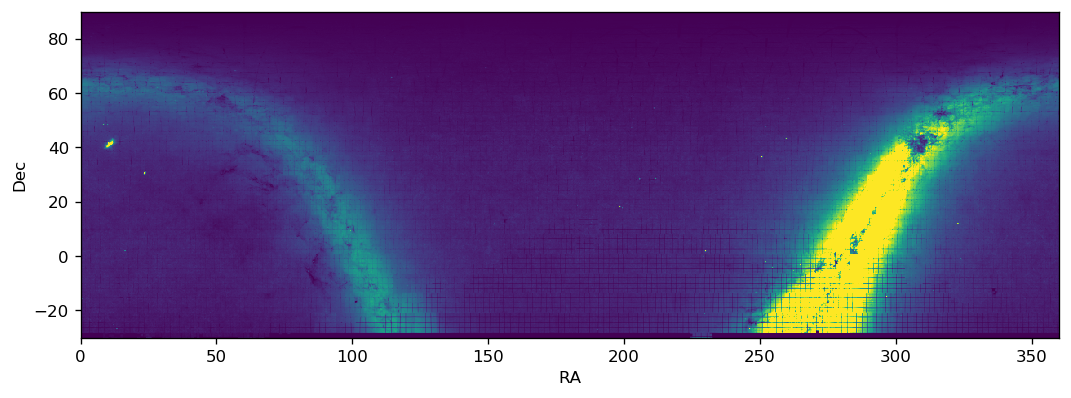

In [27]:
mult=1
plt.figure(figsize=(12*mult,3.6*mult))
extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

CPU times: user 512 ms, sys: 2.01 s, total: 2.52 s
Wall time: 1min 32s


Text(0, 0.5, 'Dec')

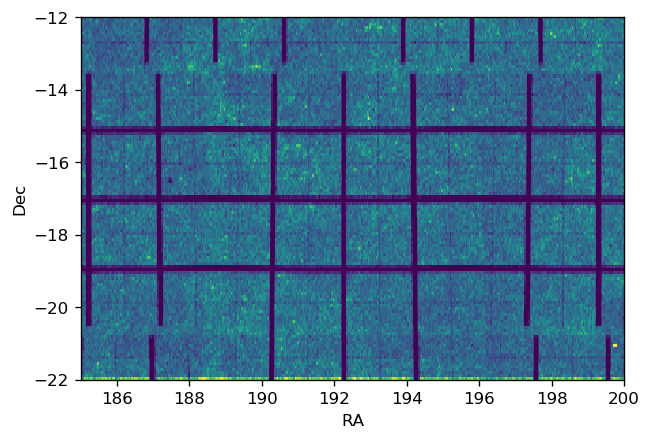

In [21]:
%%time
x,y,hist = histogram2d(ztf.where('nobs_r >0'), ztf['ra'], ztf['dec'], 400, 120, min1=185, max1=200, min2=-22, max2=-12)

extent = (185, 200, -22, -12)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [28]:
catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ps1',
 'green19_stellar_params',
 'rosat_2rxs',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ps_uband',
 'ps_uband_ver2',
 'debug_match_a',
 'debug_match_b',
 'debug_match_c',
 'ztf_rrlyr_grid_50',
 'igaps_halpha_emitters',
 'wtf_aug2020_asymmetric_2',
 'wtf_aug2020_asymmetric_3',
 'wtf_aug2020_dip_candidates',
 'ztf_rr_lyrae_preprocessed_and_gridded_09_01_2021',
 'ztf_rr_lyrae_phi_31_fits_09_01_2021',
 'stevengs_test_sources',
 'ddf_sources_bigger',
 'ztf_dr7

In [29]:
catalog.drop_table('ztf_dr14_detections')